# Basic Logistic Regression in Pytorch

In [17]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch


## Import data

In [18]:
from torchvision import datasets, transforms

# Don't need to do type hints in prod
mnist_train: torch.utils.data.Dataset = datasets.MNIST(root="./datasets", 
                                                       train=True, 
                                                       transform=transforms.ToTensor(), 
                                                       download=True)

mnist_test: torch.utils.data.Dataset = datasets.MNIST(root="./datasets", 
                                                      train=False, 
                                                      transform=transforms.ToTensor(), 
                                                      download=True)

print(f"No. of MNIST training examples: {len(mnist_train)}")
print(f"No. of MNIST test examples: {len(mnist_test)}")

No. of MNIST training examples: 60000
No. of MNIST test examples: 10000


## Plotting and manipulating the data

Image shape: torch.Size([1, 28, 28]) This means that there is 1 channel, with 28x28 pixels
Reshaped image: torch.Size([28, 28])
Label: 1


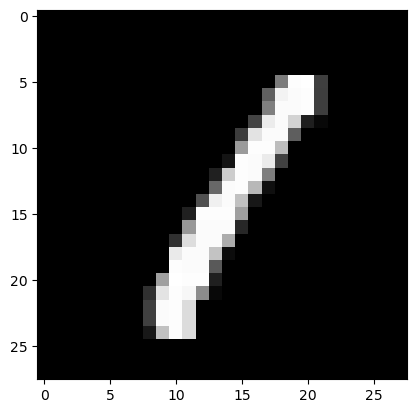

In [19]:
# Pick an arbitrary item from the training dataset
image, label = mnist_train[3]

# Plot the imagine
print(f"Image shape: {image.shape}", "This means that there is 1 channel, with 28x28 pixels")

image = image.reshape((28, 28))
print(f"Reshaped image: {image.shape}")

print(f"Label: {label}")

plt.imshow(image, cmap="gray")
plt.show()

## Using the dataloader

Images shape: torch.Size([100, 1, 28, 28])
Labels shape: torch.Size([100])
Image type: <class 'torch.Tensor'>
Label type: <class 'torch.Tensor'>


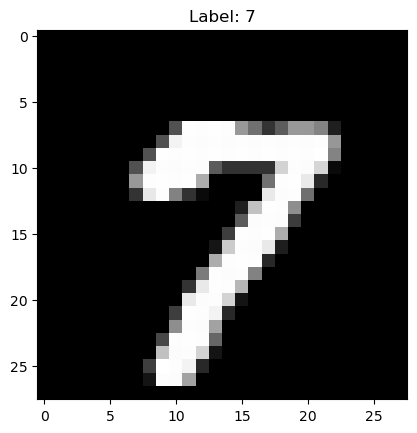

In [20]:
train_loader = torch.utils.data.DataLoader(mnist_train, 
                                           batch_size=100, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, 
                                          batch_size=100, 
                                          shuffle=False)
# print(type(train_loader))

# Get the first batch from the DataLoader
images, labels = next(iter(train_loader))

# Print shape and types
print(f"Images shape: {images.shape}")  # (batch_size, channels, height, width)
print(f"Labels shape: {labels.shape}")  # (batch_size,)
print(f"Image type: {type(images)}")    # torch.Tensor
print(f"Label type: {type(labels)}")    # torch.Tensor

plt.imshow(images[0].squeeze(), cmap="gray")  # Remove channel dim for visualization
plt.title(f"Label: {labels[0].item()}")
plt.show()

## Inference

In [21]:
input_size = 28 * 28
classes = 10


# Randomly initialize weights using "Xavier initiallization"
# 2 line initialization because the "/ np.sqrt" makes it a non-leaf tensor
W = torch.randn(input_size, classes) / np.sqrt(input_size)
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)

# flatten the input
x = images.view(-1, input_size)

# Inference
y_prime = x @ W + b # torch.matmul
print(y_prime[0, :])

# Softmax dat bih
import torch.nn.functional as F
y_hat = F.softmax(y_prime, dim=1)
print(y_hat[0, :])

tensor([ 0.4365, -0.0248, -0.1244,  0.0529, -0.0445,  0.1782,  0.4349, -0.1605,
         0.3077,  0.3166], grad_fn=<SliceBackward0>)
tensor([0.1318, 0.0831, 0.0752, 0.0898, 0.0815, 0.1018, 0.1316, 0.0725, 0.1159,
        0.1169], grad_fn=<SliceBackward0>)


## Learning

### Cross-entropy loss (aka minus log likelihood)

We defined it as "negative average log of the probability of the true label being yi given a prediction y_hat"

In [22]:
# This expects y_hat to already be softmaxed
def cross_entropy(y_hat, y):
    batch_size = y_hat.shape[0]
    log_probs = -torch.log(y_hat[range(batch_size), y]) # some fancy indexing
    return log_probs.mean()

print(f"Cross entropy from equation: {cross_entropy(y_hat, labels)}")
print(f"Cross entropy from library: {F.cross_entropy(y_prime, labels)}")

Cross entropy from equation: 2.39517879486084
Cross entropy from library: 2.39517879486084


### Back propagation

In [23]:
# Behind the scenes, all the computations for this loss are tracked by 
# torch's tensor computation graph, allowing for "autograd" features
loss = cross_entropy(y_hat, labels)
optimizer = torch.optim.SGD([W, b], lr=0.1)

# Propagate the loss backwards through the computation graph
loss.backward()
print("gradient for b: ", b.grad)
# Apply the gradient to 
optimizer.step()
print("new values for b: ", b)
optimizer.zero_grad() # clear the buffers for the numerical gradients

gradient for b:  tensor([ 0.0097, -0.0303, -0.0212, -0.0187, -0.0012, -0.0095,  0.0140, -0.0130,
        -0.0097,  0.0796])
new values for b:  tensor([-0.0010,  0.0030,  0.0021,  0.0019,  0.0001,  0.0009, -0.0014,  0.0013,
         0.0010, -0.0080], requires_grad=True)


## Iterative Training

In [ ]:
for images, labels in tqdm(train_loader):
    optimizer.zero_grad()
    
    x = images.view(-1, input_size)
    y_hat = x @ W + b # compute raw logits

    loss = F.cross_entropy(y_hat, labels)
    
    loss.backward()
    optimizer.step()

  0%|          | 0/600 [00:00<?, ?it/s]